In [ ]:
#default_exp vision.simclr

# SimCLR

> **SimCLR**: [A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/pdf/2002.05709.pdf)

> **SimCLR V2**: [Big Self-Supervised Models are Strong Semi-Supervised Learners](https://arxiv.org/pdf/2006.10029.pdf)


In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### SimCLR 

![SimCLR Framework](images/simclr.png)

SimCLR is simple contrastive training framework which uses augmented views of the same image and InfoNCE loss for training. Different views of the same image are considered positive examples whereas all the remaining negative.

#### SimCLR V2

![SimCLR V2 Framework](images/simclr_v2.png)

Changes in SimCLRV2 doesn't require much changes in the original `SimCLR` code. 

One difference is, in SimCLR V2 `MLP` module in has 3 layers instead of 2.

Another difference is using a larger model for pretraining task, e.g. it is mentioned in the original paper that scaling up the model from ResNet-50 to ResNet-152 (3×+SK) gave 29% relative gain in top-1 accuracy when fine tuning with only 1% labeled data.

Also, a few addition to data augmentation pipeline happens such as gaussian blur. Note that data augmentation utilities in this package is highly flexible and should be adjusted based on your data and problem for the best performance.

> **Qote from SimCLR V2 paper:** In our experiments, we set the width of projection head’s middle layers to that of its input, so it is also adjusted by the width multiplier. However, a wider projection head improves performance even when the base network remains narrow.

SimCLR model consists of an `encoder` and a `projector` aka MLP layer. 

In [ ]:
#export
class SimCLRModel(Module):
    "Compute predictions of concatenated xi and xj" 
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

`SimCLRModel` class can be used to create a model by passing predefined/custom `encoder` and `projector` models. Alternatively, `create_simclr_model` utility function can be used with just passing a predefined `encoder` and the expected input channels.

In [ ]:
#export
def create_simclr_model(encoder, n_in=3, hidden_size=256, projection_size=128, nlayers=2):
    "Create SimCLR model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, nlayers=2) 
    apply_init(projector)
    return SimCLRModel(encoder, projector)

Here, we use `self_supervised.layers` module to create an encoder, note that it supports all timm and fastai models for creating an encoder, either pretrained or not.

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)

We define number of input channels with `n_in`, projector/mlp's hidden size with `hidden_size`,  projector/mlp's final projection size with `projection_size` and projector/mlp's number of layers with `nlayers`.

In [ ]:
model = create_simclr_model(encoder, n_in=3, hidden_size=2048, projection_size=128, nlayers=2)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## SimCLR Callback

The following parameters can be passed; `size` for random resized cropping, `aug_func` augmentation pipeline function to be used from `self_supervised.augmentations` module, `temp` temperature scaling for cross entropy loss, `aug_kwargs` for any keyword arguments to be passed to `aug_func`.

In [ ]:
#export
class SimCLR(Callback):
    order,run_valid = 9,True
    def __init__(self, size, aug_func=get_batch_augs, temp=0.07, print_augs=False, **aug_kwargs):
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        self.temp = temp
        if print_augs: print(self.aug1), print(self.aug2)
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
    
    
    def _remove_diag(self, x):
        bs = x.shape[0]
        return x[~torch.eye(bs).bool()].reshape(bs,bs-1)    
    
    
    def lf(self, pred, *yb):
        pred, targ = F.normalize(pred, dim=1), yb[0]
        sim = self._remove_diag(pred @ pred.T) / self.temp
        targ = self._remove_diag(torch.eye(targ.shape[0], device=self.dls.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(sim, targ)
    
        
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = torch.split(self.learn.x, [bs,bs])
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

`DistributedSimCLR` is a distributed implementation of InfoNCE Loss, it effectively increases the number of negative samples to all available samples across all GPUs during loss calculation. It should be used together with DistributedDataParallel. For more details about distributed operations, see https://pytorch.org/tutorials/intermediate/dist_tuto.html.

In [ ]:
#export
class DistributedSimCLR(Callback):
    order,run_valid = 9,True
    def __init__(self, size, aug_func=get_batch_augs, temp=0.07, print_augs=False, **aug_kwargs):
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        self.temp = temp
        if print_augs: print(self.aug1), print(self.aug2)
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
    
    
    def _remove_diag(self, x):
        bs = x.shape[0]
        return x[~torch.eye(bs).bool()].reshape(bs,bs-1)    
    
    
    def lf(self, pred, *yb):
        # collect all embeddings from other GPUs
        all_preds = GatherLayer.apply(pred)
        # put current rank embeddings to index 0 for loss calc
        all_preds.pop(rank_distrib())
        all_preds = torch.cat([pred]+all_preds)
        
        pred, all_preds, targ = F.normalize(pred, dim=1), F.normalize(all_preds, dim=1), yb[0]
        sim = self._remove_diag(pred @ all_preds.T) / self.temp
        targ = self._remove_diag(torch.eye(targ.shape[0], device=self.dls.device)[targ]).nonzero()[:,-1]
        return F.cross_entropy(sim, targ)
    
        
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = torch.split(self.learn.x, [bs,bs])
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_simclr_model(fastai_encoder, n_in=1, hidden_size=2048, projection_size=128)
learn = Learner(dls, model, cbs=[SimCLR(size=28, aug_func=get_batch_augs,
                            rotate=False, jitter=False, bw=False, blur=False,
                            stats=None, cuda=False),
                     ShortEpochCallback(0.001)])

Also, with `show_one()` method you can inspect data augmentations as a sanity check. You can use existing augmentation functions from `augmentations` module.

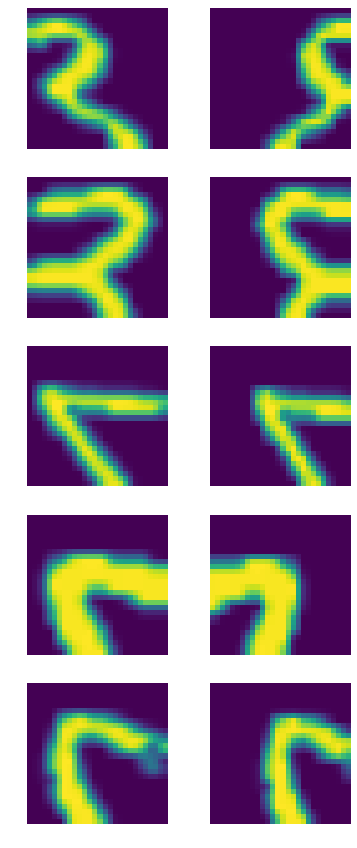

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(1.7770)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01-augmentations.ipynb.
Converted 02-layers.ipynb.
Converted 03-distributed.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 11-byol.ipynb.
Converted 12-swav.ipynb.
Converted 13-moco.ipynb.
Converted index.ipynb.
